In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv("/home/karthikponna/kittu/Energy generation prediction project/Energy-Generation-Predictor-MLops/data/dataset/EnergyData.csv",parse_dates=[0])
df = df.sort_values(by="period",ascending=True).reset_index(drop=True)
df.head()

,period,respondent,respondent-name,fueltype,type-name,value,value-units
0,2022-01-01 00:00:00,NY,New York,WAT,Hydro,3962,megawatthours
1,2022-01-01 01:00:00,NY,New York,WAT,Hydro,3970,megawatthours
2,2022-01-01 02:00:00,NY,New York,WAT,Hydro,3963,megawatthours
3,2022-01-01 03:00:00,NY,New York,WAT,Hydro,3750,megawatthours
4,2022-01-01 04:00:00,NY,New York,WAT,Hydro,3513,megawatthours


In [3]:
from datetime import timedelta

df['Seconds'] = df["period"].map(pd.Timestamp.timestamp)
columnstodrop = ['respondent','respondent-name','fueltype','type-name','value-units']
df.drop(columns=columnstodrop, axis=1, inplace=True) 
print(type(df))
df.head()

# Constants for cyclic features
day = 60 * 60 * 24
year = timedelta(days=365.2425).total_seconds()
hour = 60 * 60
minute = 60 

# Extract cyclic features
df['Day sin'] = np.sin(2 * np.pi * df['Seconds'] / day)
df['Day cos'] = np.cos(2 * np.pi * df['Seconds'] / day)
df['Year sin'] = np.sin(2 * np.pi * df['Seconds'] / year)
df['Year cos'] = np.cos(2 * np.pi * df['Seconds'] / year)

# Extract hours and minutes
df['Hour'] = (df['Seconds'] // hour) % 24
df['Minute'] = (df['Seconds'] // minute) % 60

# Cyclic encoding for hours and minutes
df['Hour sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Minute sin'] = np.sin(2 * np.pi * df['Minute'] / 60)
df['Minute cos'] = np.cos(2 * np.pi * df['Minute'] / 60)

# Convert seconds to datetime to extract month
df['Datetime'] = pd.to_datetime(df['Seconds'], unit='s', origin='unix')
df['Month'] = df['Datetime'].dt.month

# Cyclic encoding for months
df['Month sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month cos'] = np.cos(2 * np.pi * df['Month'] / 12)

# Drop unnecessary columns
df = df.drop(['Seconds', 'Hour', 'Minute', 'Month', 'Datetime','period'], axis=1) 
df.head()

<class 'pandas.core.frame.DataFrame'>


,value,Day sin,Day cos,Year sin,Year cos,Hour sin,Hour cos,Minute sin,Minute cos,Month sin,Month cos
0,3962,-8.652299e-12,1.000000,0.006709,0.999977,0.000000,1.000000,0.0,1.0,0.5,0.866025
1,3970,2.588190e-01,0.965926,0.007426,0.999972,0.258819,0.965926,0.0,1.0,0.5,0.866025
2,3963,5.000000e-01,0.866025,0.008143,0.999967,0.500000,0.866025,0.0,1.0,0.5,0.866025
3,3750,7.071068e-01,0.707107,0.008859,0.999961,0.707107,0.707107,0.0,1.0,0.5,0.866025
4,3513,8.660254e-01,0.500000,0.009576,0.999954,0.866025,0.500000,0.0,1.0,0.5,0.866025


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25561 entries, 0 to 25560
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   value       25561 non-null  int64  
 1   Day sin     25561 non-null  float64
 2   Day cos     25561 non-null  float64
 3   Year sin    25561 non-null  float64
 4   Year cos    25561 non-null  float64
 5   Hour sin    25561 non-null  float64
 6   Hour cos    25561 non-null  float64
 7   Minute sin  25561 non-null  float64
 8   Minute cos  25561 non-null  float64
 9   Month sin   25561 non-null  float64
 10  Month cos   25561 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 2.1 MB


In [5]:
def df_to_X_y(df, timestep=24): 
    df_as_np = df.to_numpy()
    X = []
    y = [] 
    for i in range(len(df_as_np) - timestep):
        # Use all columns for X
        row = df_as_np[i:i + timestep]
        X.append(row)
        # Only use the target column ('value') for y
        label = df_as_np[i + timestep][0]  # Target value
        y.append(label) 
    return np.array(X), np.array(y)

FEATURES, TARGET = df_to_X_y(df, timestep=12)
print("X shape:", FEATURES.shape)  # Should be (n_samples, timestep, n_features)
print("y shape:", TARGET.shape)  # Should be (n_samples,)

X shape: (25549, 12, 11)
y shape: (25549,)


In [6]:
# Create limits to divide the trainging, validation and test sets
training_limit = int(len(FEATURES) * 0.7)
print(f'training_limit: {training_limit}') 
rest = len(FEATURES)-training_limit
print(f'remaining: {rest}') 
validation_limit = int(rest*0.4)
print(f'validation_limit: {validation_limit}')

training_limit: 17884
remaining: 7665
validation_limit: 3066


In [7]:
# Generating training, validation and test sets
X_train, y_train = FEATURES[:training_limit], TARGET[:training_limit]
X_val, y_val = FEATURES[training_limit:(training_limit+validation_limit)], TARGET[training_limit:(training_limit+validation_limit)]
X_test, y_test = FEATURES[(training_limit+validation_limit):], TARGET[(training_limit+validation_limit):]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((17884, 12, 11), (17884,), (3066, 12, 11), (3066,), (4599, 12, 11), (4599,))

In [8]:
from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)) 
y_val_scaled = scaler.transform(y_val.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.reshape(-1, 1))   
y_train_scaled.shape,y_val_scaled.shape,y_test_scaled.shape


((17884, 1), (3066, 1), (4599, 1))

### LSTM

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

2025-01-05 12:31:43.102934: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-05 12:31:43.933673: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-05 12:31:44.454203: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736080305.070107   41550 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736080305.152058   41550 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-05 12:31:46.156382: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [23]:
lstm = Sequential()
lstm.add(InputLayer((12, 11)))
lstm.add(LSTM(64))
lstm.add(Dense(128))
lstm.add(Dense(64))
lstm.add(Dense(64))
lstm.add(Dense(64))
lstm.add(Dropout(0.3))
lstm.add(Dense(64))
lstm.add(Dropout(0.3))
lstm.add(Dense(16))
lstm.add(Dense(8, 'relu'))
lstm.add(Dense(1, 'linear'))

lstm.summary()
cp_lstm = ModelCheckpoint('/home/karthikponna/kittu/Energy generation prediction project/Energy-Generation-Predictor-MLops/notebooks/models/lstm.keras', save_best_only=True)
lstm.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
lstm.fit(X_train, y_train_scaled, validation_data=(X_val, y_val_scaled), epochs=50, callbacks=[cp_lstm])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,697 (194.13 KB)

 Trainable params: 49,697 (194.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 0.1094 - root_mean_squared_error: 0.3119 - val_loss: 0.0271 - val_root_mean_squared_error: 0.1646
Epoch 2/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.0278 - root_mean_squared_error: 0.1666 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1117
Epoch 3/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.0104 - root_mean_squared_error: 0.1019 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0558
Epoch 4/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.0079 - root_mean_squared_error: 0.0891 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0687
Epoch 5/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.0071 - root_mean_squared_error: 0.0844 - val_loss: 0.0062 - val_root_mean_squared_error: 0.0789
Epoch 6/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.0061 - root_mean_squared_error: 0.0782 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0563
Epoch 7/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(model, X_test, y_test, scaler, plot_range=100):  
    predictions = model.predict(X_test).flatten() 
    predictions_rescaled = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    actuals_rescaled = scaler.inverse_transform(y_test).flatten() 
    results_df = pd.DataFrame({
        'Predictions': predictions_rescaled,
        'Actuals': actuals_rescaled
    })
    print(f"Shape of y_pred_rescaled: {predictions_rescaled.shape}, Shape of y_test_rescaled:{actuals_rescaled.shape}")
    mae = mean_absolute_error(actuals_rescaled, predictions_rescaled)
    mse = mean_squared_error(actuals_rescaled, predictions_rescaled)
    rmse = np.sqrt(mse)
    r2 = r2_score(actuals_rescaled, predictions_rescaled)

    metrics = {
        'Mean Absolute Error (MAE)': mae,
        'Mean Squared Error (MSE)': mse,
        'Root Mean Squared Error (RMSE)': rmse,
        'R² Score': r2
    } 
    print("Evaluation Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
        
    plt.figure(figsize=(15, 5))
    plt.plot(results_df['Actuals'][:plot_range], label='Actuals', linestyle='-', color='blue', markersize=10)
    plt.plot(results_df['Predictions'][:plot_range], label='Predictions', linestyle='--', color='red', markersize=10)
    plt.title('Actuals vs Predictions')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
 
    return results_df

2025-01-04 20:43:18.258188: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9442752 exceeds 10% of free system memory.


559/559 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step
Evaluation Metrics:
Mean Absolute Error (MAE): 140.76874646839747
Mean Squared Error (MSE): 35578.04014431503
Root Mean Squared Error (RMSE): 188.62142016302133
R² Score: 0.9083673001362309


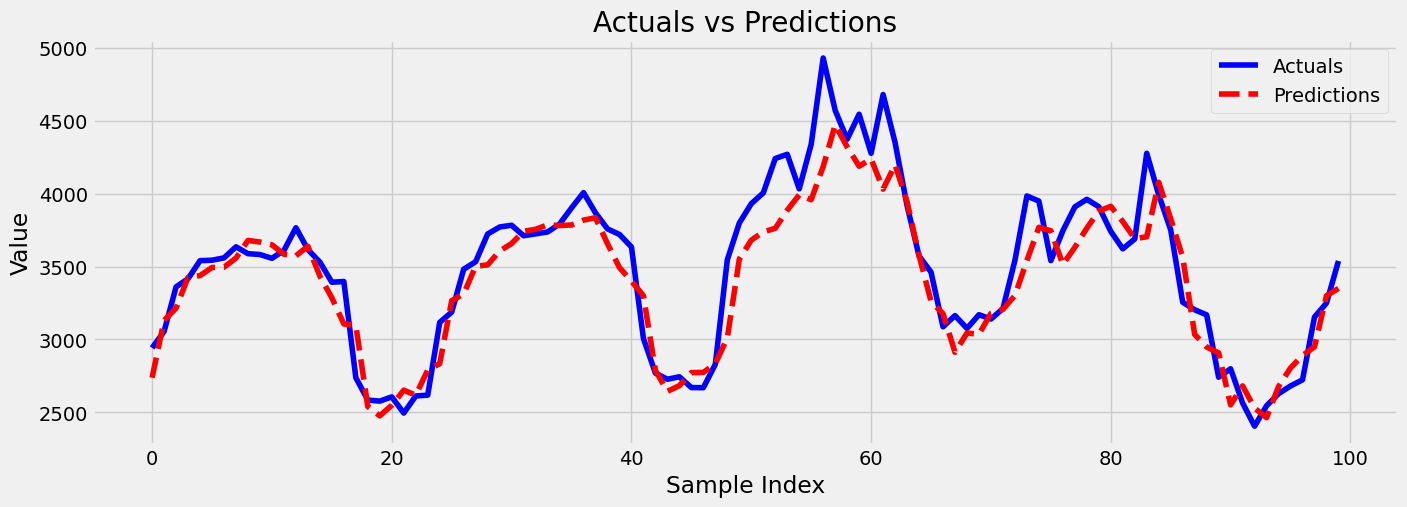

,Predictions,Actuals
0,2737.766113,2942.0
1,3130.266357,3055.0
2,3215.145264,3361.0
3,3427.018311,3417.0
4,3438.378906,3541.0
...,...,...
17879,2656.657959,2580.0
17880,2818.913330,3030.0
17881,3209.838867,3718.0
17882,3653.544434,3770.0


In [25]:
lstm_train_metrics = evaluate_model(lstm, X_train, y_train_scaled, scaler, plot_range=100)
lstm_train_metrics

96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Evaluation Metrics:
Mean Absolute Error (MAE): 132.67786062580265
Mean Squared Error (MSE): 30640.246878596303
Root Mean Squared Error (RMSE): 175.0435570896464
R² Score: 0.8872335279729684


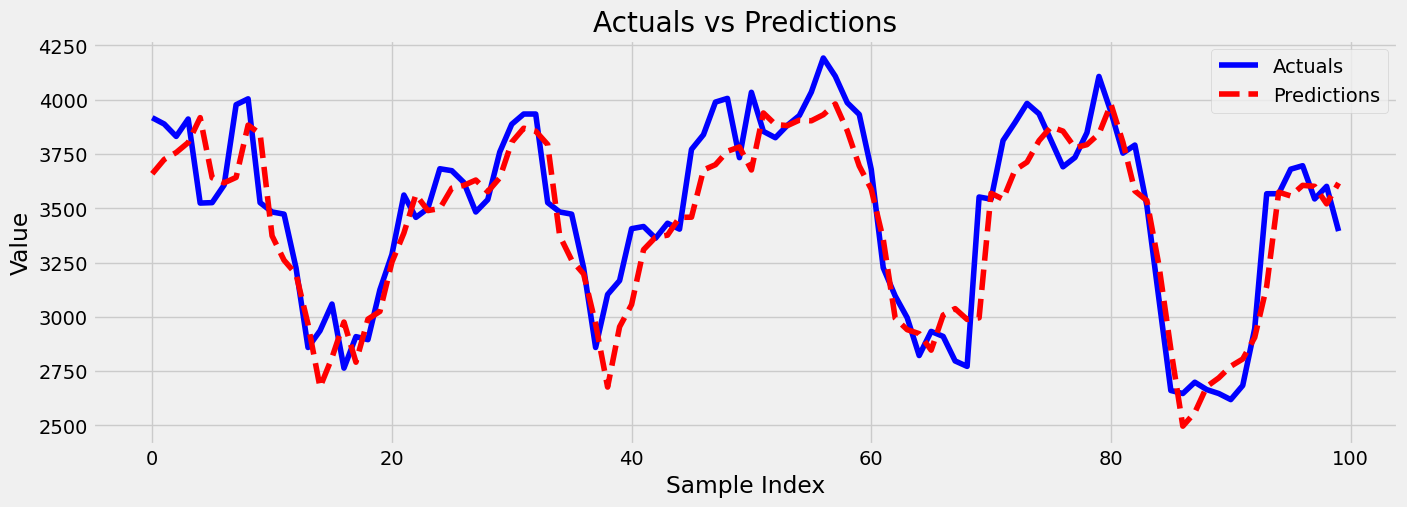

,Predictions,Actuals
0,3658.959229,3917.0
1,3724.851562,3888.0
2,3756.855713,3831.0
3,3802.666992,3911.0
4,3917.326904,3524.0
...,...,...
3061,1772.884888,2421.0
3062,2290.538818,2302.0
3063,2211.987305,2290.0
3064,2285.577881,2253.0


In [26]:
lstm_val_metrics = evaluate_model(lstm, X_val, y_val_scaled, scaler, plot_range=100)
lstm_val_metrics

144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Evaluation Metrics:
Mean Absolute Error (MAE): 136.56440537451246
Mean Squared Error (MSE): 36102.9032807553
Root Mean Squared Error (RMSE): 190.00764005890738
R² Score: 0.906104487602521


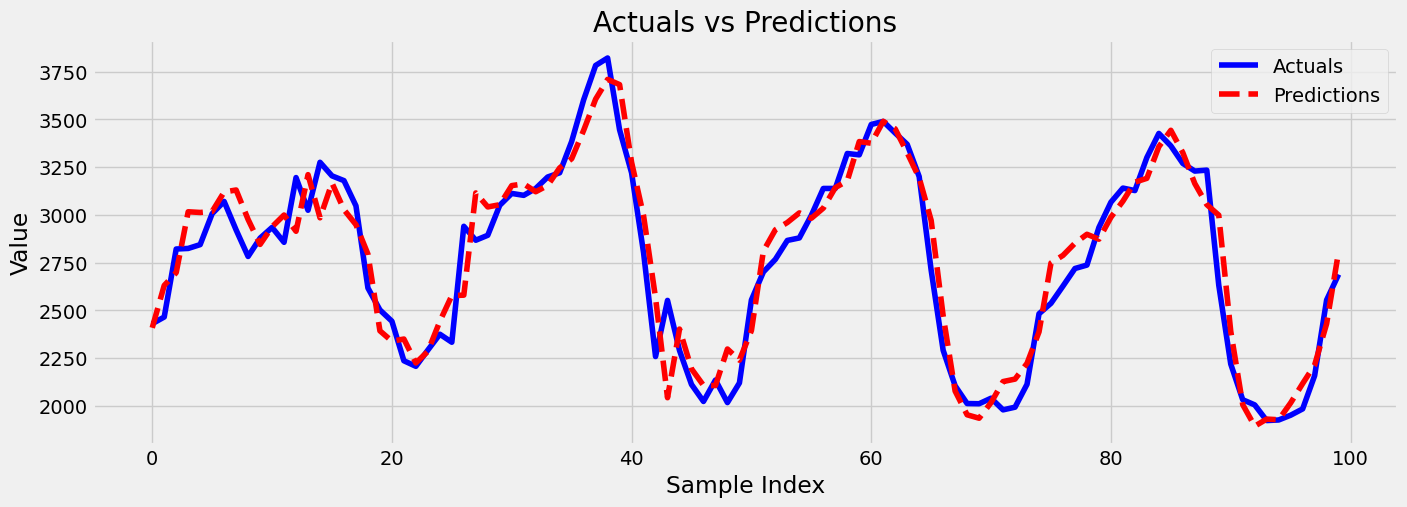

,Predictions,Actuals
0,2408.426025,2430.0
1,2630.260742,2465.0
2,2697.465332,2821.0
3,3015.947021,2824.0
4,3012.327148,2844.0
...,...,...
4594,3081.968506,2972.0
4595,3072.684814,3387.0
4596,3466.306152,3591.0
4597,3608.530762,3630.0


In [27]:
lstm_test_metrics= evaluate_model(lstm, X_test, y_test_scaled, scaler, plot_range=100)
lstm_test_metrics

### GRU

In [28]:
gru = Sequential()
gru.add(InputLayer((12,11)))
gru.add(GRU(64))
gru.add(Dense(128))
gru.add(Dense(64))
gru.add(Dense(64))
gru.add(Dense(64))
gru.add(Dropout(0.3))
gru.add(Dense(64))
gru.add(Dropout(0.3))
gru.add(Dense(16))
gru.add(Flatten())
gru.add(Dense(8, 'relu'))
gru.add(Dense(1, 'linear'))

gru.summary()
cp_gru = ModelCheckpoint('/home/karthikponna/kittu/Energy generation prediction project/Energy-Generation-Predictor-MLops/notebooks/models/gru.keras', save_best_only=True)
gru.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

gru.fit(X_train, y_train_scaled, validation_data=(X_val, y_val_scaled), epochs=50, callbacks=[cp_gru])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        14,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,025 (175.88 KB)

 Trainable params: 45,025 (175.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


2025-01-04 20:46:07.892892: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9442752 exceeds 10% of free system memory.


559/559 ━━━━━━━━━━━━━━━━━━━━ 28s 23ms/step - loss: 0.2767 - root_mean_squared_error: 0.4780 - val_loss: 0.0287 - val_root_mean_squared_error: 0.1693
Epoch 2/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.0318 - root_mean_squared_error: 0.1782 - val_loss: 0.0199 - val_root_mean_squared_error: 0.1409
Epoch 3/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.0268 - root_mean_squared_error: 0.1638 - val_loss: 0.0222 - val_root_mean_squared_error: 0.1491
Epoch 4/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - loss: 0.0243 - root_mean_squared_error: 0.1559 - val_loss: 0.0164 - val_root_mean_squared_error: 0.1281
Epoch 5/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.0212 - root_mean_squared_error: 0.1457 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1113
Epoch 6/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.0193 - root_mean_squared_error: 0.1387 - val_loss: 0.0111 - val_root_mean_squared_error: 0.1051
Epoch 7/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/st

2025-01-04 20:56:38.514601: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9442752 exceeds 10% of free system memory.


559/559 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step
Evaluation Metrics:
Mean Absolute Error (MAE): 152.763644265158
Mean Squared Error (MSE): 41492.378991842794
Root Mean Squared Error (RMSE): 203.69678198695922
R² Score: 0.8931346781505947


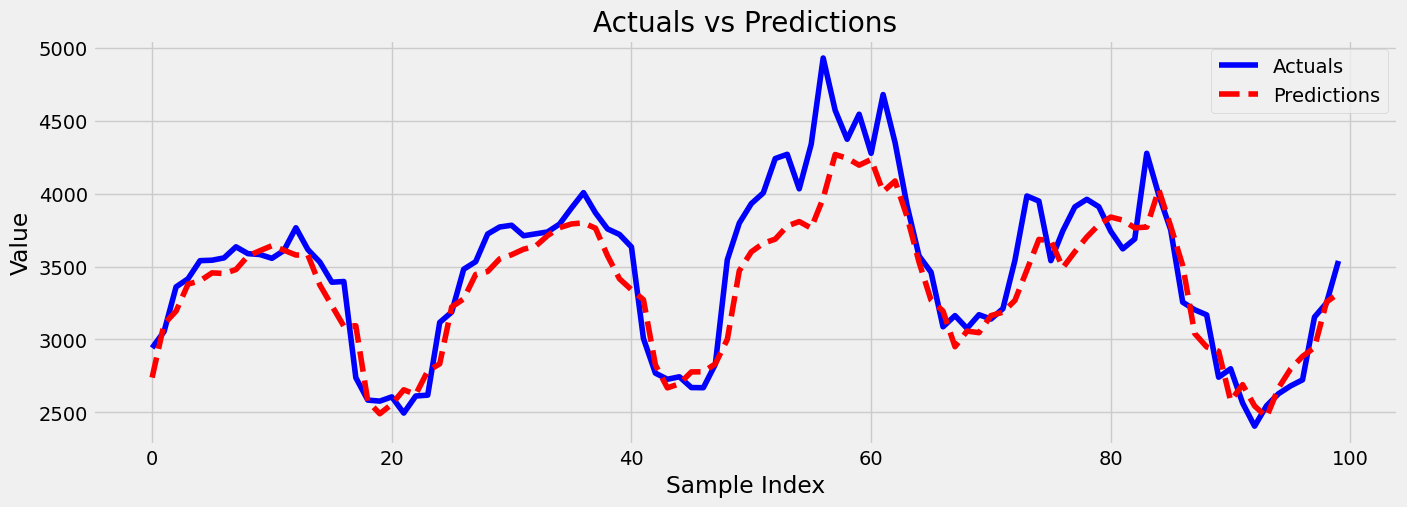

,Predictions,Actuals
0,2738.462891,2942.0
1,3106.556641,3055.0
2,3194.840576,3361.0
3,3380.146729,3417.0
4,3402.572266,3541.0
...,...,...
17879,2645.876221,2580.0
17880,2802.567871,3030.0
17881,3167.438232,3718.0
17882,3563.196777,3770.0


In [29]:
gru_train_metrics = evaluate_model(gru, X_train, y_train_scaled, scaler, plot_range=100)
gru_train_metrics

96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Evaluation Metrics:
Mean Absolute Error (MAE): 155.04373123158993
Mean Squared Error (MSE): 39984.1432085178
Root Mean Squared Error (RMSE): 199.96035409179942
R² Score: 0.8528448290735604


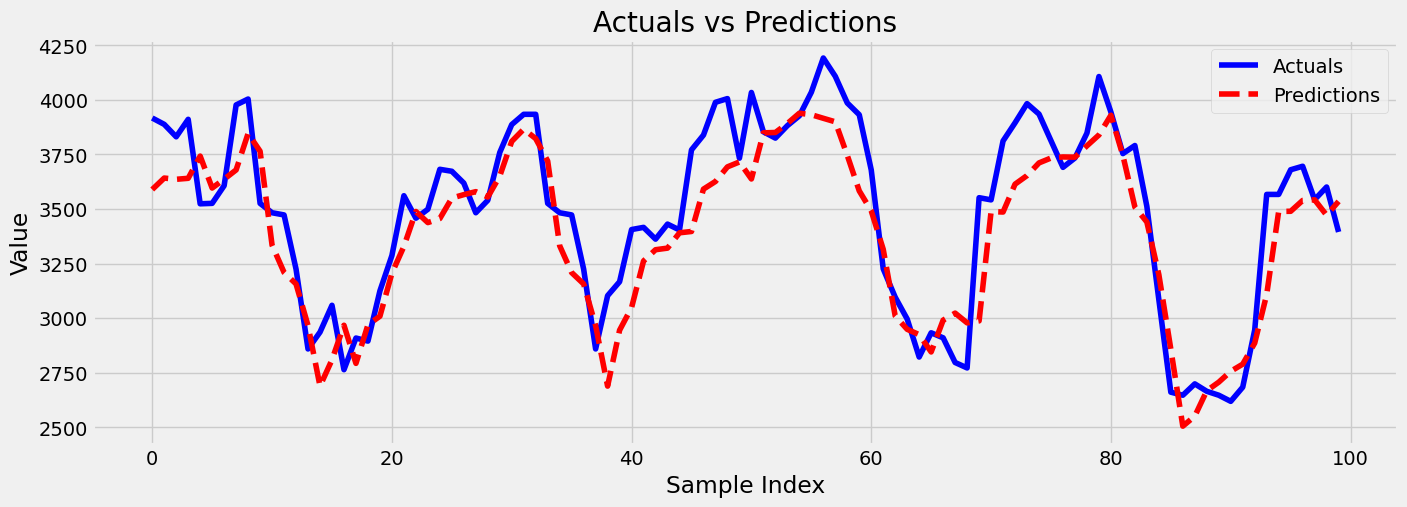

,Predictions,Actuals
0,3589.497803,3917.0
1,3641.939697,3888.0
2,3636.268066,3831.0
3,3640.812988,3911.0
4,3742.655762,3524.0
...,...,...
3061,1543.013306,2421.0
3062,2244.296631,2302.0
3063,2195.845215,2290.0
3064,2267.135742,2253.0


In [30]:
gru_val_metrics = evaluate_model(gru, X_val, y_val_scaled, scaler, plot_range=100)
gru_val_metrics

144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Evaluation Metrics:
Mean Absolute Error (MAE): 147.78517931568854
Mean Squared Error (MSE): 43759.33503864734
Root Mean Squared Error (RMSE): 209.1873204538156
R² Score: 0.8861918346656361


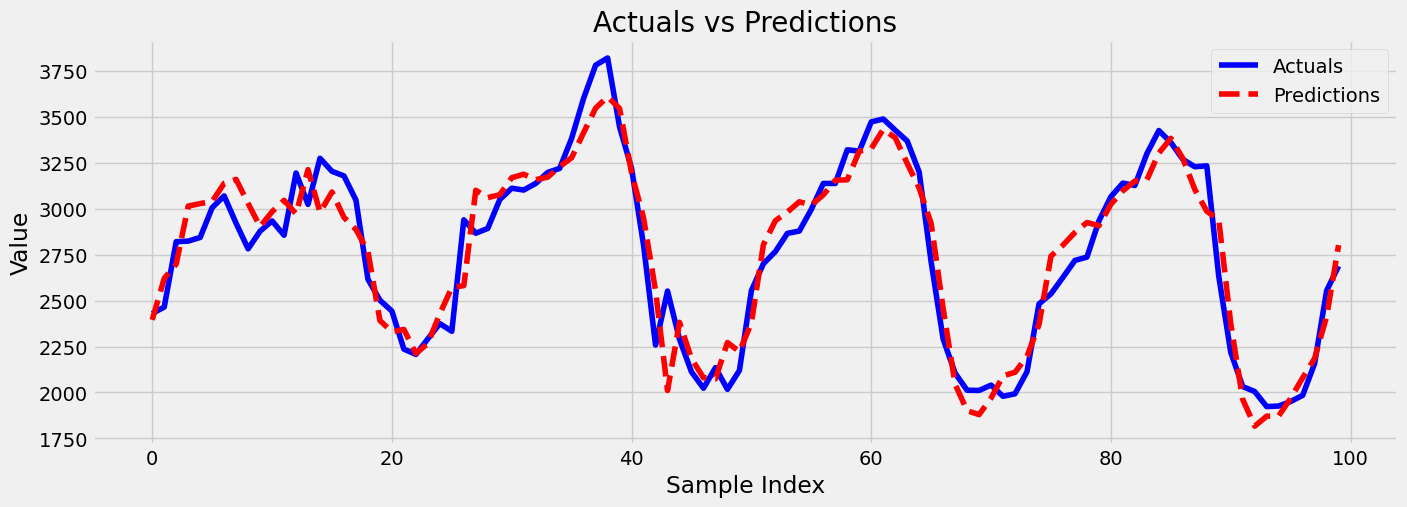

,Predictions,Actuals
0,2395.040283,2430.0
1,2620.876465,2465.0
2,2699.220947,2821.0
3,3014.713867,2824.0
4,3028.591309,2844.0
...,...,...
4594,3084.263672,2972.0
4595,3090.947510,3387.0
4596,3429.623779,3591.0
4597,3567.313477,3630.0


In [31]:
gru_test_metrics = evaluate_model(gru, X_test, y_test_scaled,scaler, plot_range=100)
gru_test_metrics

### 1D Convolutional Neural Network

In [15]:
conv = Sequential()
conv.add(InputLayer((12, 11)))
conv.add(Conv1D(64, kernel_size=2)) 
conv.add(Dense(64))
conv.add(Dropout(0.3))
conv.add(Dense(64))
conv.add(Dropout(0.3))
conv.add(Dense(16))
conv.add(Flatten())
conv.add(Dense(8, 'relu'))
conv.add(Dense(1, 'linear')) 
conv.summary()
cp_conv = ModelCheckpoint('/home/karthikponna/kittu/Energy generation prediction project/Energy-Generation-Predictor-MLops/notebooks/models/conv.keras', save_best_only=True)
conv.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()]) 
conv.fit(X_train, y_train_scaled, validation_data=(X_val, y_val_scaled), epochs=50, callbacks=[cp_conv])

2025-01-05 12:32:05.010525: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 11, 64)         │         1,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 11, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 11, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 11, 16)         │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 176)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,257 (47.88 KB)

 Trainable params: 12,257 (47.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


2025-01-05 12:32:05.465423: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9442752 exceeds 10% of free system memory.


559/559 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 99682.9453 - root_mean_squared_error: 283.0245 - val_loss: 222.9713 - val_root_mean_squared_error: 14.9322
Epoch 2/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 1379.0248 - root_mean_squared_error: 36.9228 - val_loss: 0.3205 - val_root_mean_squared_error: 0.5661
Epoch 3/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 226.2924 - root_mean_squared_error: 14.8978 - val_loss: 0.3195 - val_root_mean_squared_error: 0.5652
Epoch 4/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 123.8800 - root_mean_squared_error: 10.9722 - val_loss: 0.3204 - val_root_mean_squared_error: 0.5660
Epoch 5/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 74.4304 - root_mean_squared_error: 8.4234 - val_loss: 0.3162 - val_root_mean_squared_error: 0.5623
Epoch 6/50
559/559 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 61.2871 - root_mean_squared_error: 7.5004 - val_loss: 0.3074 - val_root_mean_squared_error: 0.5544
Epoch 7/50
559/559 ━━━━━━━━━━━━━━━━

  1/559 ━━━━━━━━━━━━━━━━━━━━ 1:21 145ms/step

2025-01-05 12:37:24.593301: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 9442752 exceeds 10% of free system memory.


559/559 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Shape of y_pred_rescaled: (17884,), Shape of y_test_rescaled:(17884,)
Evaluation Metrics:
Mean Absolute Error (MAE): 319.01342985033324
Mean Squared Error (MSE): 155800.72198589245
Root Mean Squared Error (RMSE): 394.71600168461936
R² Score: 0.5987288580713732


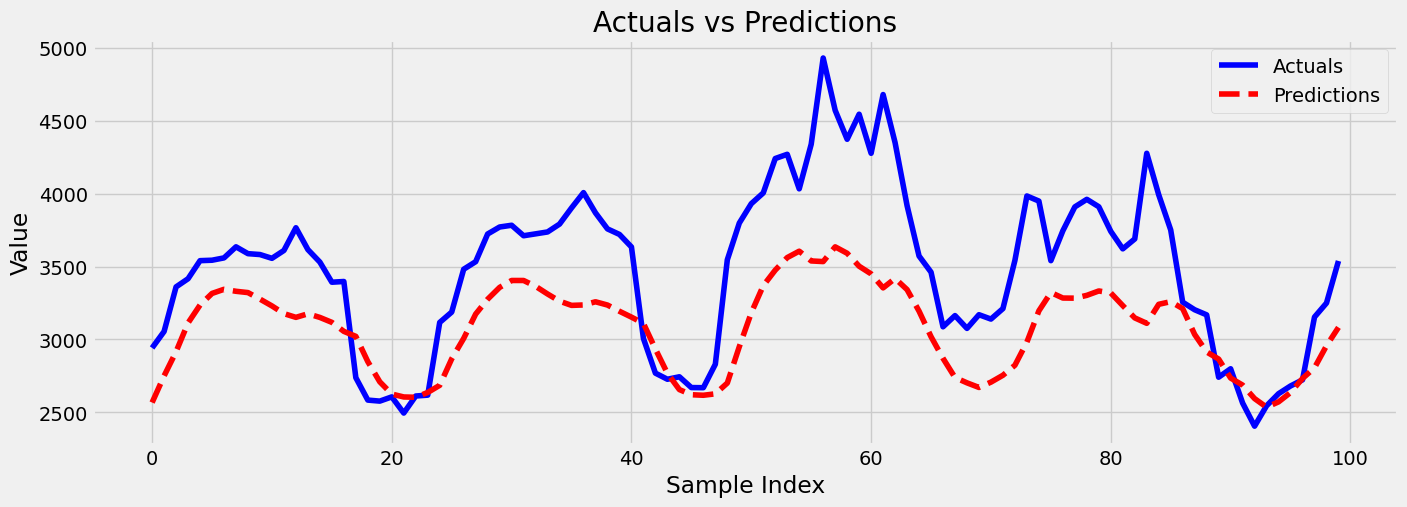

,Predictions,Actuals
0,2567.120361,2942.0
1,2750.062012,3055.0
2,2916.369873,3361.0
3,3113.614014,3417.0
4,3236.418701,3541.0
...,...,...
17879,2504.434082,2580.0
17880,2580.658203,3030.0
17881,2766.903320,3718.0
17882,3080.381592,3770.0


In [16]:
conv_train_metrics = evaluate_model(conv, X_train, y_train_scaled, scaler, plot_range=100)
conv_train_metrics

96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Shape of y_pred_rescaled: (3066,), Shape of y_test_rescaled:(3066,)
Evaluation Metrics:
Mean Absolute Error (MAE): 378.1898008621524
Mean Squared Error (MSE): 207869.42211865398
Root Mean Squared Error (RMSE): 455.9269920926529
R² Score: 0.23497021850065836


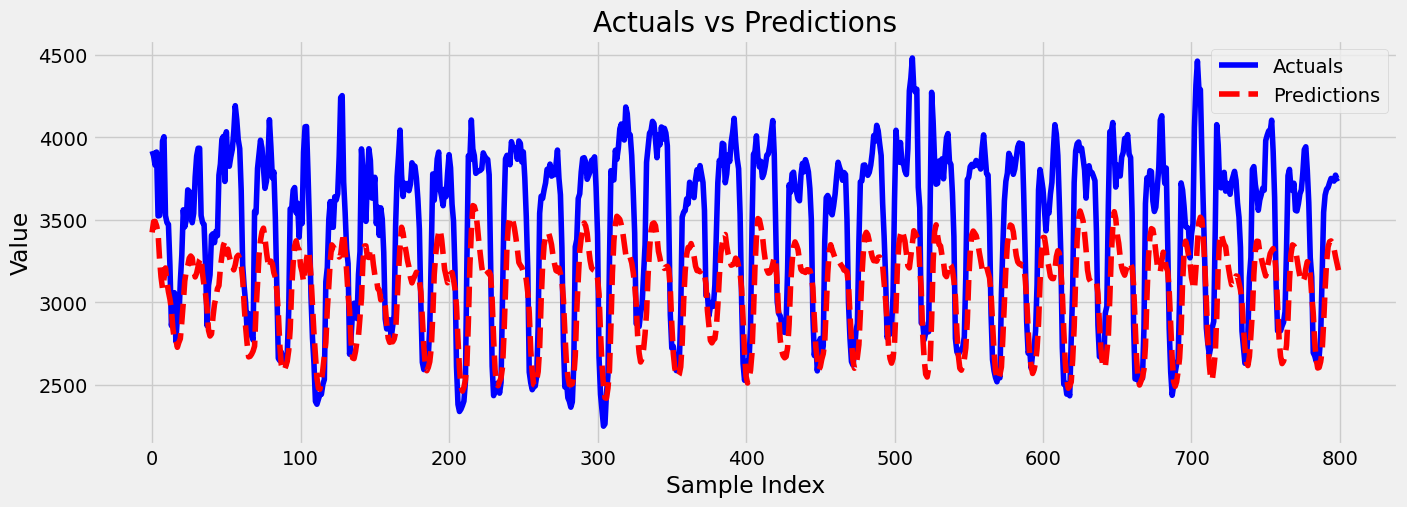

,Predictions,Actuals
0,3424.100098,3917.0
1,3489.052734,3888.0
2,3490.919434,3831.0
3,3464.816406,3911.0
4,3423.067627,3524.0
...,...,...
3061,2610.853271,2421.0
3062,2636.383057,2302.0
3063,2638.564941,2290.0
3064,2660.071777,2253.0


In [17]:
conv_val_metrics = evaluate_model(conv, X_val, y_val_scaled, scaler, plot_range=800)
conv_val_metrics

144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Shape of y_pred_rescaled: (4599,), Shape of y_test_rescaled:(4599,)
Evaluation Metrics:
Mean Absolute Error (MAE): 309.21320510403075
Mean Squared Error (MSE): 149409.0220104824
Root Mean Squared Error (RMSE): 386.5346323558633
R² Score: 0.6114208165092765


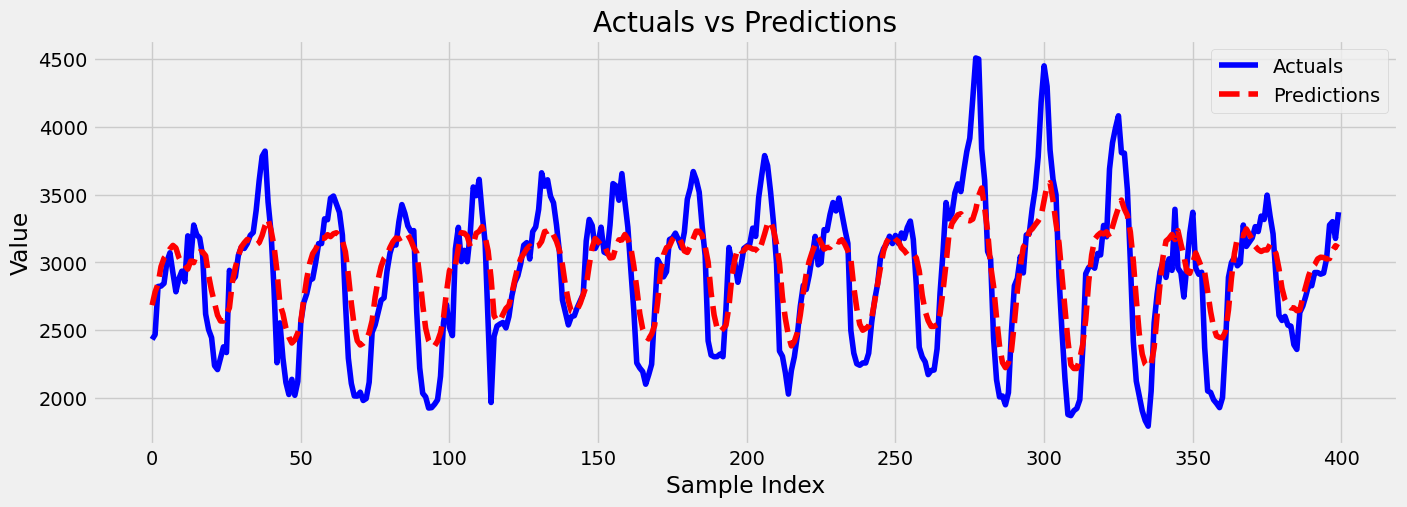

,Predictions,Actuals
0,2682.628662,2430.0
1,2779.281250,2465.0
2,2841.295654,2821.0
3,2967.956055,2824.0
4,3030.034424,2844.0
...,...,...
4594,3181.685059,2972.0
4595,3118.414307,3387.0
4596,3168.629150,3591.0
4597,3240.293945,3630.0


In [ ]:
conv_test_metrics = evaluate_model(conv, X_test, y_test_scaled, scaler, plot_range=400)
conv_test_metrics